# SOXL Algorithm #1 - EMA10_SMA50 Cross

In [1]:
from alpaca.trading.client import TradingClient
from alpaca.trading.requests import GetAssetsRequest
from alpaca.trading.requests import MarketOrderRequest, LimitOrderRequest, GetOrdersRequest
from alpaca.trading.enums import AssetClass, OrderSide, TimeInForce, QueryOrderStatus

from alpaca.data.live import StockDataStream, CryptoDataStream

from alpaca.data import StockHistoricalDataClient, StockTradesRequest, StockLatestQuoteRequest

import matplotlib.pyplot as plt

from datetime import datetime, timedelta, timezone
import datetime
import json

from pprint import pprint

from talipp.indicators import EMA, ATR, SMA

from pandas import json_normalize

import asyncio
import logging
import sys

import nest_asyncio
import requests

In [2]:
ema_n = EMA(period= 10)
ema_n_high = EMA(period= 10)
ema_n_low = EMA(period= 10)
sma_n = SMA(period= 50)
atr_n = ATR(period= 2)

In [3]:
# Initialize the CryptoDataStream & TradingClient for live trading with Alpaca API credentials
#stream = CryptoDataStream(os.environ['ALPACA_K'], os.environ['ALPACA_SK'])
stream = StockDataStream(os.environ['ALPACA_K'], os.environ['ALPACA_SK'])
trading_client = TradingClient(os.environ["ALPACA_K"], os.environ["ALPACA_SK"])
data_client = StockHistoricalDataClient(os.environ["ALPACA_K"], os.environ["ALPACA_SK"])

Account Info 

In [4]:
# Account information function
async def account_info_print():

    if account.status == 'ACTIVE':
        print('Account status is {}.'.format(account.status))
    else:
        print('Account status is {}.'.format(account.status))

    print('${} is available as cash.'.format(account.cash))

    if account.account_blocked:
        print('Account is blocked.')

    if account.long_market_value:
        print('${} is available as long market value.'.format(account.long_market_value))

    if account.short_market_value:
        print('${} is available as short market value.'.format(account.short_market_value))

    if account.equity:
        print('${} is available as equity.'.format(account.equity))

    print('${} is the total portfolio value.'.format(account.portfolio_value))

    print('${} is available as buying power.'.format(account.buying_power))

    if account.daytrading_buying_power:
        print('${} is available as day trading buying power.'.format(account.daytrading_buying_power))

    if account.regt_buying_power:
        print('${} is available as Reg-T buying power.'.format(account.regt_buying_power))

    if account.pending_transfer_in:
        print('${} is available as pending transfers in.'.format(account.pending_transfer_in))

    if account.pending_transfer_out:
        print('${} is available as pending transfers out.'.format(account.pending_transfer_out))

    if account.multiplier:
        print('Account is currently using a leverage of {}x.'.format(account.multiplier))

    if account.initial_margin:
        print('${} is available as initial margin.'.format(account.initial_margin))

    if account.maintenance_margin:
        print('${} is available as maintenance margin.'.format(account.maintenance_margin))

    #-------------------------------------------------------------------------------
    # Account flags

    if account.trade_suspended_by_user:
        print('Account trade is suspended by user.')

    if account.daytrade_count:
        print('Account is currently has {} daytrade(s).'.format(account.daytrade_count))

    if account.pattern_day_trader:
        print('Account is currently set as a pattern day trader.')

    if account.trading_blocked:
        print('Account is currently restricted from trading.')

    if account.transfers_blocked:
        print('Account is currently restricted from trading transfers.')

start: 2025-09-30
end: 2025-09-30
[33.86, 33.82, 33.86, 33.85, 33.74, 33.7, 33.685, 33.63, 33.73, 33.75, 33.82, 33.78, 33.775, 33.815, 33.79, 33.8, 33.82, 33.82, 33.82, 33.82, 33.83, 33.82, 33.83, 33.79, 33.8, 33.84, 33.82, 33.87, 33.87, 33.84, 33.82, 33.86, 33.895, 33.89, 33.93, 33.93, 33.91, 33.91, 33.92, 33.91, 33.92, 33.93, 33.92, 33.94, 33.91, 33.91, 33.93, 33.98, 34.0, 34.04, 34.02, 34.03, 34.06, 34.02, 34.03, 33.99, 34.0, 33.95, 33.95, 33.95, 33.97, 33.89, 33.9, 33.9, 33.92, 33.98, 33.95, 33.94, 33.91, 33.91, 33.94, 33.94, 33.92, 33.92, 33.93, 33.94, 33.91, 33.93, 33.92, 33.9, 33.92, 33.92, 33.93, 33.94, 33.94, 33.94, 33.95, 33.96, 34.02, 34.015, 34.02, 34.05, 34.05, 34.04, 34.005, 34.0, 33.95, 33.97, 33.97, 33.975, 33.98, 33.97, 33.99, 33.985, 33.98, 33.965, 33.95, 33.95, 33.97, 33.935, 33.935, 33.955, 33.94, 33.98, 33.99, 33.965, 33.96, 33.97, 33.97, 33.955, 33.97, 33.99, 33.99, 34.0, 34.01, 34.0, 34.01, 34.03, 34.0, 34.0, 34.005, 33.975, 33.96, 33.96, 33.93, 33.92, 33.95, 33.

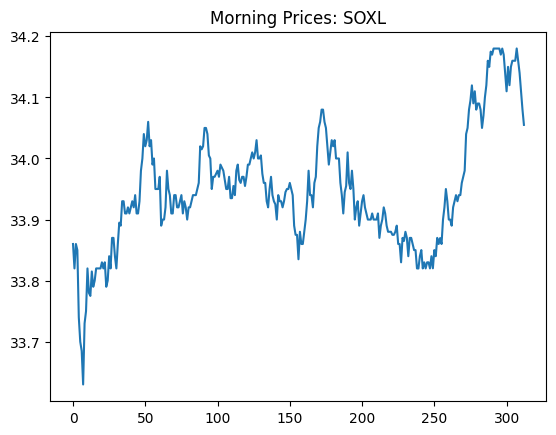

In [5]:
ticker = 'SOXL'
today = datetime.date.today()
start = today + datetime.timedelta(days=0)
end = today + datetime.timedelta(days=0)
print(f"start: {start}")
print(f"end: {end}")


#url = f"https://data.alpaca.markets/v2/stocks/{ticker}/bars?timeframe=1Min&start={start}&end={end}&limit=10000&adjustment=raw&feed=sip&sort=asc"

# Use url below for sip data
url = "https://data.alpaca.markets/v2/stocks/SOXL/bars?timeframe=1Min&limit=10000&adjustment=raw&feed=sip&sort=asc"

headers = {
    "accept": "application/json",
    "APCA-API-KEY-ID": os.environ['ALPACA_K'],
    "APCA-API-SECRET-KEY": os.environ['ALPACA_SK'] 
}

response = requests.get(url, headers=headers)

response_json = response.json()
layer = response_json['bars']

early_day_bars_df = json_normalize(layer)

starting_closing_prices = early_day_bars_df['c'].tolist()
print(starting_closing_prices)

ys = starting_closing_prices
xs = [x for x in range(len(ys))]

plt.plot(xs, ys)
plt.title("Morning Prices: " + ticker)
plt.show()
plt.close()

In [6]:
# Add the first closing price indicators to the list for the trading to start near the market open
ema_n.add_input_value(starting_closing_prices)
sma_n.add_input_value(starting_closing_prices)

/tmp/ipykernel_142/1485134099.py:2: DeprecationWarning: This method is deprecated and will be removed in the next major version. Please use add(...) method with the same signature instead.
  ema_n.add_input_value(starting_closing_prices)
/tmp/ipykernel_142/1485134099.py:3: DeprecationWarning: This method is deprecated and will be removed in the next major version. Please use add(...) method with the same signature instead.
  sma_n.add_input_value(starting_closing_prices)


Version 8.1

Set account and time variables.

In [7]:
from datetime import datetime

# Get account information
account = trading_client.get_account()
clock = trading_client.get_clock()

# Get the current UTC time
now_utc = datetime.utcnow()
reg_mkt_close_utc = datetime.utcnow().replace(hour=19, minute=55, second=0, microsecond=0)

This function clear_all_positions() is to clear all positions before the market closes.

In [8]:
# Add logic to clear all soxl or soxs positions 5-10 mins before market close
# Remember to change hours in March due to daylight savings; from 14:30 - 21:00 to 13:30 - 20:00

async def clear_all_positions():

    # Get the current UTC time
    now_utc = datetime.utcnow()
    reg_mkt_close_utc = datetime.utcnow().replace(hour=21, minute=0, second=0, microsecond=0)

    # Calculate the difference in minutes
    time_difference = reg_mkt_close_utc - now_utc
    minutes_difference = time_difference.total_seconds() // 60  # Convert seconds to minutes
    hrs_left = int(minutes_difference)/60
    mins_left = ((int(minutes_difference)/60)-int(hrs_left))*60
    print(f"Amount of time until 20:00 UTC is {int(hrs_left)} hrs and {int(mins_left)} mins")

    if int(hrs_left) < 1 and int(mins_left) < 6:
        print(f"Market is due to close in less than {int(mins_left)} minutes. Clearing all positions.")
        trading_client.close_all_positions()
        try:
            await stream.stop()  # Stops the WebSocket stream
            loop.stop()
        except ValueError as e:
            print(f"Exiting clear_all_positions() function error: {e}")
            sys.exit(0)

This function wait_for_buying_power() is to delay for 1 second the calculation for buying power available.

In [9]:
async def wait_for_buying_power(min_required, timeout=10):

    start_time = asyncio.get_running_loop().time()
    while asyncio.get_running_loop().time() - start_time < timeout:
        account = trading_client.get_account()
        if float(account.buying_power) >= min_required:
            return True
        await asyncio.sleep(1)  # Check every second

    return False

The function execute_trade_logic() will take the close_price variable and determine when to buy or sell. This is the main decision logic. 

In [10]:
async def execute_trade_logic(close_price):

    await clear_all_positions()
    print("")

    # Get current quotes for SOXL and SOXS
    request_params = StockLatestQuoteRequest(symbol_or_symbols=["SOXL", "SOXS"])
    bars = data_client.get_stock_latest_quote(request_params)

    # Set ask prices for SOXL and SOXS
    soxl_ask_price = bars["SOXL"].ask_price
    soxs_ask_price = bars["SOXS"].ask_price

    # Get all positions from the trading client
    positions = trading_client.get_all_positions()

    # Initialize variables to store positions in SOXL and SOXS
    soxl_position = None
    soxs_position = None

    # Iterate through all positions to check if we hold SOXL or SOXS
    for position in positions:
        if position.symbol == "SOXL":
            soxl_position = position  # Store the SOXL position if found
        elif position.symbol == "SOXS":
            soxs_position = position  # Store the SOXS position if found

    # Access the most recent values of EMA and SMA
    current_ema_n = ema_n[-1]
    current_sma_n = sma_n[-1]

    # Ensure EMA and SMA values start at the same time
    current_ema_n = current_ema_n if current_sma_n is not None else 0
    current_sma_n = current_sma_n if current_sma_n is not None else 0

    # Determine the quantity to buy based on 90% of available buying power
    buying_power = float(account.cash)

    soxl_qty_to_buy = int(float((buying_power * 0.9)) / float(soxl_ask_price))
    soxs_qty_to_buy = int(float((buying_power * 0.9)) / float(soxs_ask_price))

    soxl_approx_cost = soxl_qty_to_buy * float(soxl_ask_price)
    soxs_approx_cost = soxs_qty_to_buy * float(soxs_ask_price)

    #### Trading logic

    if current_ema_n > current_sma_n:  # Bullish
        if soxs_position:
            sell_order = MarketOrderRequest(
                symbol="SOXS",
                qty=int(float(soxs_position.qty)),
                side=OrderSide.SELL,
                time_in_force=TimeInForce.DAY,
            )
            trading_client.submit_order(sell_order)
            print("Sold SOXS")
            await asyncio.sleep(2)  # Wait to ensure the sell order is processed

            # Wait for buying power to be available
            if not await wait_for_buying_power(soxl_qty_to_buy * soxl_ask_price):
                print("Insufficient buying power after selling SOXS. Exiting.")
                return

        if not soxl_position:
            buy_order = MarketOrderRequest(
                symbol="SOXL",
                qty=soxl_qty_to_buy,
                side=OrderSide.BUY,
                time_in_force=TimeInForce.DAY,
            )
            trading_client.submit_order(buy_order)
            print(f"--> BULL Bought {soxl_qty_to_buy} shares of SOXL")
        else:
            print("--> BULL Already holding SOXL; no action taken.")  # Log that we're holding SOXL and did nothing

    elif current_ema_n < current_sma_n:  # Bearish
        if soxl_position:
            sell_order = MarketOrderRequest(
                symbol="SOXL",
                qty=int(float(soxl_position.qty)),
                side=OrderSide.SELL,
                time_in_force=TimeInForce.DAY,
            )
            trading_client.submit_order(sell_order)
            print("Sold SOXL")
            await asyncio.sleep(2)  # Wait to ensure the sell order is processed

            # Wait for buying power to be available
            if not await wait_for_buying_power(soxs_qty_to_buy * soxs_ask_price):
                print("Insufficient buying power after selling SOXL. Exiting.")
                return

        if not soxs_position:
            buy_order = MarketOrderRequest(
                symbol="SOXS",
                qty=soxs_qty_to_buy,
                side=OrderSide.BUY,
                time_in_force=TimeInForce.DAY,
            )
            trading_client.submit_order(buy_order)
            print(f"--> BEAR Bought {soxs_qty_to_buy} shares of SOXS")
        else:
            print("--> BEAR Already holding SOXS; no action taken.")  # Log that we're holding SOXS and did nothing
            
    else:
        print("--> EMA and SMA are equal; no action taken.")
    print("---------------------------------------------------------------------")

The handle_trade() function will receive bar data "trade" from the stream.run() command.

In [11]:
# Function to handle trade updates
async def handle_trade(trade):

    # Update the technical indicators with the latest trade data

    ema_n.add_input_value(trade.close)
    sma_n.add_input_value(trade.close)
    atr_n.add_input_value(trade)

    current_ema_n = ema_n[-1]
    current_sma_n = sma_n[-1]

    # Print values of indicators for reference
    print(f"EMA N: {current_ema_n}")
    print(f"SMA N: {current_sma_n}")
    print(f"Volume: {trade.volume:.2f}")
    print(f"Trade Count: {trade.trade_count:.2f}")
    print(f"Timestamp: {trade.timestamp}")

    close_price = trade.close

    try:
        # Execute the trading logic based on the actual closing price
        await execute_trade_logic(close_price)
    except ValueError as e:
            print(f"Exiting handle_trade() function error: {e}")
            loop.stop()

In [12]:
# Subscribe to trade updates for SOXL
stream.subscribe_bars(handle_trade, "SOXL")

The function main() is the first layer. Beings the stream.run() command to start the websocket.

In [13]:
# Function to run the WebSocket stream using asyncio
async def main():
    if not clock.is_open:
    #if clock.is_open:
        raise ValueError("Market is closed. Exiting program. Next market open: " + str(clock.next_open))
        loop.stop()
    try:
        await stream.run()  # Starts the WebSocket stream
    except ValueError as e:
        print(f"Exiting main() function error: {e}")
        sys.exit(0)

# Check if you're in an environment that needs nest_asyncio
try:
    import nest_asyncio
    nest_asyncio.apply()  # Allow nested event loops if necessary
except ImportError:
    pass

In [14]:
asyncio.run(main())

Traceback (most recent call last):
  File "/root/venv/lib/python3.9/site-packages/alpaca/common/rest.py", line 198, in _one_request
    response.raise_for_status()
  File "/root/venv/lib/python3.9/site-packages/requests/models.py", line 1026, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 403 Client Error: Forbidden for url: https://paper-api.alpaca.markets/v2/orders

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/root/venv/lib/python3.9/site-packages/alpaca/data/live/websocket.py", line 346, in _run_forever
    await self._consume()
  File "/root/venv/lib/python3.9/site-packages/alpaca/data/live/websocket.py", line 164, in _consume
    await self._dispatch(msg)
  File "/root/venv/lib/python3.9/site-packages/alpaca/data/live/websocket.py", line 262, in _dispatch
    await handler(self._cast(msg))
  File "/tmp/ipykernel_142/1305562048.py", line 24, in handle_trade
   

TimeoutError: 

Version 8

In [12]:
'''
# Get account information
account = trading_client.get_account()
clock = trading_client.get_clock()

# Get the current UTC time
now_utc = datetime.utcnow()
reg_mkt_close_utc = datetime.utcnow().replace(hour=20, minute=0, second=0, microsecond=0)

# Function to execute trade logic
async def wait_for_buying_power(min_required, timeout=10):

    start_time = asyncio.get_running_loop().time()
    while asyncio.get_running_loop().time() - start_time < timeout:
        account = trading_client.get_account()
        if float(account.buying_power) >= min_required:
            return True
        await asyncio.sleep(1)  # Check every second

    return False
    
# Add logic to clear all soxl or soxs positions 5-10 mins before market close
async def clear_all_positions():
    if now_utc > reg_mkt_close_utc:
        print("The target time (20:00 UTC) has already passed.")
    else:
        # Calculate the difference in minutes
        time_difference = reg_mkt_close_utc - now_utc
        minutes_difference = time_difference.total_seconds() // 60  # Convert seconds to minutes
        mkt_closing_countdown = int(minutes_difference)
        print(f"The number of minutes until 20:00 UTC: {int(minutes_difference)}")

async def execute_trade_logic(close_price):

    clear_all_positions()

    # Get current quotes for SOXL and SOXS
    request_params = StockLatestQuoteRequest(symbol_or_symbols=["SOXL", "SOXS"])
    bars = data_client.get_stock_latest_quote(request_params)

    # Set ask prices for SOXL and SOXS
    soxl_ask_price = bars["SOXL"].ask_price
    soxs_ask_price = bars["SOXS"].ask_price

    # Get all positions from the trading client
    positions = trading_client.get_all_positions()

    # Initialize variables to store positions in SOXL and SOXS
    soxl_position = None
    soxs_position = None

    # Iterate through all positions to check if we hold SOXL or SOXS
    for position in positions:
        if position.symbol == "SOXL":
            soxl_position = position  # Store the SOXL position if found
        elif position.symbol == "SOXS":
            soxs_position = position  # Store the SOXS position if found

    # Access the most recent values of EMA and SMA
    current_ema_n = ema_n[-1]
    current_sma_n = sma_n[-1]

    # Ensure EMA and SMA values start at the same time
    current_ema_n = current_ema_n if current_sma_n is not None else 0
    current_sma_n = current_sma_n if current_sma_n is not None else 0

    # Determine the quantity to buy based on 90% of available buying power
    buying_power = float(account.cash)

    soxl_qty_to_buy = int(float((buying_power * 0.9)) / float(soxl_ask_price))
    soxs_qty_to_buy = int(float((buying_power * 0.9)) / float(soxs_ask_price))

    soxl_approx_cost = soxl_qty_to_buy * float(soxl_ask_price)
    soxs_approx_cost = soxs_qty_to_buy * float(soxs_ask_price)


    #### Trading logic

    if current_ema_n > current_sma_n:  # Bullish
        if soxs_position:
            sell_order = MarketOrderRequest(
                symbol="SOXS",
                qty=int(float(soxs_position.qty)),
                side=OrderSide.SELL,
                time_in_force=TimeInForce.DAY,
            )
            trading_client.submit_order(sell_order)
            print("Sold SOXS")
            await asyncio.sleep(2)  # Wait to ensure the sell order is processed

            # Wait for buying power to be available
            if not await wait_for_buying_power(soxl_qty_to_buy * soxl_ask_price):
                print("Insufficient buying power after selling SOXS. Exiting.")
                return

        if not soxl_position:
            buy_order = MarketOrderRequest(
                symbol="SOXL",
                qty=soxl_qty_to_buy,
                side=OrderSide.BUY,
                time_in_force=TimeInForce.DAY,
            )
            trading_client.submit_order(buy_order)
            print(f"--> BULL Bought {soxl_qty_to_buy} shares of SOXL")
        else:
            print("--> BULL Already holding SOXL; no action taken.")  # Log that we're holding SOXL and did nothing

    elif current_ema_n < current_sma_n:  # Bearish
        if soxl_position:
            sell_order = MarketOrderRequest(
                symbol="SOXL",
                qty=int(float(soxl_position.qty)),
                side=OrderSide.SELL,
                time_in_force=TimeInForce.DAY,
            )
            trading_client.submit_order(sell_order)
            print("Sold SOXL")
            await asyncio.sleep(2)  # Wait to ensure the sell order is processed

            # Wait for buying power to be available
            if not await wait_for_buying_power(soxs_qty_to_buy * soxs_ask_price):
                print("Insufficient buying power after selling SOXL. Exiting.")
                return

        if not soxs_position:
            buy_order = MarketOrderRequest(
                symbol="SOXS",
                qty=soxs_qty_to_buy,
                side=OrderSide.BUY,
                time_in_force=TimeInForce.DAY,
            )
            trading_client.submit_order(buy_order)
            print(f"--> BEAR Bought {soxs_qty_to_buy} shares of SOXS")
        else:
            print("--> BEAR Already holding SOXS; no action taken.")  # Log that we're holding SOXS and did nothing
            
    else:
        print("--> EMA and SMA are equal; no action taken.")
    print("---------------------------------------------------------------------")

# Function to handle trade updates
async def handle_trade(trade):

    # Update the technical indicators with the latest trade data

    ema_n.add_input_value(trade.close)
    sma_n.add_input_value(trade.close)
    atr_n.add_input_value(trade)

    close_price = trade.close

    # Print values of indicators for reference
    print(f"EMA N: {ema_n}")
    print(f"SMA N: {sma_n}")
    print(f"ATR N: {atr_n}")

    # Print trade update in a more readable format
    print("\nTrade Update")
    print(f"Symbol: {trade.symbol}")
    print(f"Timestamp: {trade.timestamp}")
    print(f"Open: {trade.open:.2f}")
    print(f"High: {trade.high:.2f}")
    print(f"Low: {trade.low:.2f}")
    print(f"Close: {trade.close:.2f}")
    print(f"Volume: {trade.volume:.2f}")
    print(f"Trade Count: {trade.trade_count:.2f}")
    print(f"VWAP: {trade.vwap:.2f}\n")

    # Print account information
    account_info_print()
    
    try:
        # Execute the trading logic based on the actual closing price
        await execute_trade_logic(close_price)
    except ValueError as e:
            print(f"Exiting program level 2 error: {e}")
            sys.exit(0)

# Subscribe to trade updates for SOXL
stream.subscribe_bars(handle_trade, "SOXL")

# Function to run the WebSocket stream using asyncio
async def main():
    if not clock.is_open:
    #if clock.is_open:
        raise ValueError(
            "Market is closed. Exiting program. Next market open: "
            + str(clock.next_open)
        )
        loop.stop()
    try:
        await stream.run()  # Starts the WebSocket stream
    except ValueError as e:
        print(f"Exiting program level 1 error: {e}")
        sys.exit(0)

# Check if you're in an environment that needs nest_asyncio
try:
    import nest_asyncio

    nest_asyncio.apply()  # Allow nested event loops if necessary
except ImportError:
    pass
'''

In [ ]:
# Run the main function
#await main()  # Use await here instead of asyncio.run()
#asyncio.run(main())

/tmp/ipykernel_155/4145522848.py:145: DeprecationWarning: This method is deprecated and will be removed in the next major version. Please use add(...) method with the same signature instead.
  ema_n.add_input_value(trade.close)
/tmp/ipykernel_155/4145522848.py:146: DeprecationWarning: This method is deprecated and will be removed in the next major version. Please use add(...) method with the same signature instead.
  sma_n.add_input_value(trade.close)
/tmp/ipykernel_155/4145522848.py:147: DeprecationWarning: This method is deprecated and will be removed in the next major version. Please use add(...) method with the same signature instead.
  atr_n.add_input_value(trade)
/tmp/ipykernel_155/4145522848.py:34: RuntimeWarning: coroutine 'clear_all_positions' was never awaited
  clear_all_positions()
EMA N: [None]
SMA N: [None]
ATR N: [None]

Trade Update
Symbol: SOXL
Timestamp: 2024-09-26 13:34:00+00:00
Open: 39.94
High: 40.08
Low: 39.72
Close: 39.73
Volume: 43519.00
Trade Count: 154.00
VWAP